In [1]:
import torch
from torch import Tensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from kymatio.torch import Scattering1D

import h5py
import numpy as np
import pandas as pd
import pywt

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

cuda


Микросейсмический мониторинг является одним из современных методов анализа геофизического состояния исследуемого объекта: месторождения полезных ископаемых, крупномасштабные промышленные объекты и т. д. Он включает в себя систему датчиков, фиксирующих слабые сейсмические или акустические сигналы, систему сбора данных и алгоритмы их обработки. Основной задачей мониторинга является определение характеристик микросейсмического события: времени первого вступления, магнитуды, его месторасположения в пространстве.

Задача данной работы – построение метода анализа волновых форм сигналов, полученных в ходе микросейсмического мониторинга с целью локализации координат источников сейсмических событий. На данном этапе работы решается задача выделения времён вступления отдельных фаз сейсмической волны. 

Основным отличием предлагаемого подхода от большинства ранее представленных является использование синтетических волновых форм для формирования обучающей выборки. Преимущество такого подхода состоит в том, что для синтетических данных заранее известны все необходимые параметры каждого сейсмического события (время вступления, координаты источника, магнитуда, параметры механизма источника, скоростная модель среды). Это дает возможность создавать и обучать модели на данных, сформированных с учётом особенностей, характерных для заданного района проведения мониторинга. Кроме того, такой подход, в отличие от использования банков реальных волновых форм для обучения модели, исключает возможность искажения результатов, связанную с применением ручной разметкой данных.

### Загрузка датасета. Сам датасет должен находиться на гугл диске, скачать можно по ссылке ниже.


In [ ]:
# # datasets should exist on google drive
# drive.mount('/gdrive')
# !cp -a /gdrive/MyDrive/seismo_datasets/. /content/data/

Mounted at /gdrive


**Датасеты**:
https://drive.google.com/drive/folders/1hWSmVs57WeA2XBkUNjTgDhIPmksp6kbo?usp=sharing


*100k_wforms_disp_5stax3ch_with_saw_06_03_23.hdf5.hdf5* - датасет с синтетическими волновыми формами. Датасет представляет собой hdf5 файл с записями волновых ворм и двумя датафреймами: с параметрами принимающих станций (координаты, коды каналов, частота дискретизации) и данными по параметрам события (координаты источника, параметры механизма источника) и временами прихода отдельных фаз на каждую из станций.  В блоке ниже - примеры получения данных из файла датасета.
  
 Синтетические  волновые формы моделировались при помощи Pyrocko (https://pyrocko.org/) – набора python библиотек для сейсмологического моделирования с открытым исходным кодом (Heimann et al., 2017). Распространение сейсмических волн моделировалось для упруго-вязкой слоистой среды. Скоростная модель среды была взята из работы (Málek et al., 2005) . Выбор определялся наличием в свободном доступе предварительно рассчитанных функций Грина, необходимых для получения волновых форм. Источники сейсмических сигналов моделировались двойной парой сил со случайным распределением направлений смещения (strike, deep, rake) и магнитудами, *равномерно* распределёнными в заданных границах (0 - 2). Эпицентры и глубины источников задавались случайным образом внутри области с радиусом 1.5 км и глубиной 1000 метров. Волновые формы (смещение) были получены для пяти станций (четыре симметрично расположены на расстоянии 500 метров от начала координат, и одна в центре) для трёх каналов (два горизонтальных N,E и вертикальный Z). Для каждой волновой формы были получены априорные моменты первого прихода p и s волны. Всего в датасете 10**5 событий.

*SAKH-2014_2021_global_norm.h5* - датасет реальной сейсмики Сахалина от из работы [Stepnov et al., 2021] (https://www.mdpi.com/1424-8220/21/18/6290) (взят отсюда https://github.com/jamm1985/seismo-performer). Данные размечены для выделения классификации сигнала. Не совсем то, что мне нужно. 

***Датасет калтеха*** - https://scedc.caltech.edu/data/deeplearning.html 20ГБ волновых форм. Планирую пытаться валидировать свои модели на нём.

Heimann, S., Kriegerowski, M., Isken, M., Cesca, S., Daout, S., Grigoli, F., Juretzek, C., Megies, T., Nooshiri, N., Steinberg, A., Sudhaus, H., Vasyura-Bathke, H., Willey, T., & Dahm, T. (2017). Pyrocko - An open-source seismology toolbox and library. https://doi.org/10.5880/GFZ.2.1.2017.001

Málek, J., Horálek, J., & Janský, J. (2005). One-Dimensional qP-Wave Velocity Model of the Upper Crust for the West Bohemia/Vogtland Earthquake Swarm Region. Studia Geophysica et Geodaetica 2005 49:4, 49(4), 501–524. https://doi.org/10.1007/S11200-005-0024-2

Stepnov, A.; Chernykh, V.; Konovalov, A. The Seismo-Performer: A Novel Machine Learning Approach for General and Efficient Seismic Phase Recognition from Local Earthquakes in Real Time. Sensors 2021, 21, 6290. https://doi.org/10.3390/s21186290

<KeysViewHDF5 ['events', 'sta0', 'sta1', 'sta2', 'sta3', 'sta4', 'stations_info']>
<KeysViewHDF5 ['arrivals', 'traces']>
<KeysViewHDF5 ['E', 'N', 'Z']>
0.8301578
[0.8301578  0.95753574 0.54443765 ... 0.8761627  0.60287815 1.0733824 ]


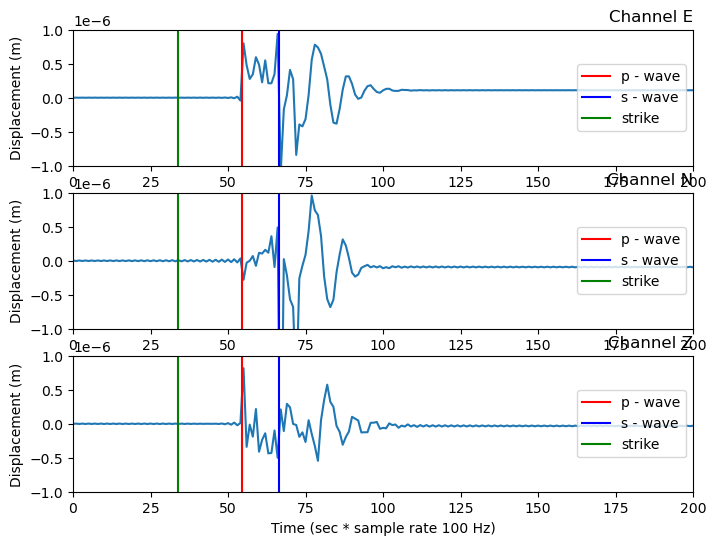

In [2]:
h5_path = '100k_wforms_disp_5stax3ch_with_saw_06_03_23.hdf5'

with h5py.File(h5_path, 'r') as f:
    '''get root'''
    pp = f.keys()
    print(pp)

with h5py.File(h5_path, 'r') as f:
    '''get list of station 1 (sta1) items'''
    pp = f["sta1"].keys()
    print(pp)

with h5py.File(h5_path, 'r') as f:
    '''get list of traces on sta1'''
    pp = f["sta1/traces"].keys()
    print(pp)

with h5py.File(h5_path, 'r') as f:
    '''get sta1 Z channel first trace'''
    pp = f["sta1/traces/Z"][0]
    # print(pp)

with h5py.File(h5_path, 'r') as f:
    '''get its p arrival'''
    pp = f["sta1/arrivals/p"][0]
    print(pp)

with h5py.File(h5_path, 'r') as f:
    '''get list of p arrivals on sta1'''
    pp = f["sta1/arrivals/p"][:]
    print(pp)

'''how to get station_info DataFrame'''
si = pd.read_hdf(h5_path, '/stations_info')
si.head()

'''how to get events list'''
arr = pd.read_hdf(h5_path, '/events')
arr.head()

'''some using way'''
sample_rate = si['smpl_rate_hz'][0]

trace_no = 2 # event
sta = 1 # sta num
chnlz = 'ENZ' # channel codes

fig, ax = plt.subplots(3,1, figsize=(8,6))
with h5py.File(h5_path, 'r') as f:
    for ii, ch in enumerate(chnlz):
        ax[ii].set_xlim(0,200)
        ax[ii].set_ylim(-1e-6,1e-6)
        ax[ii].plot(f[f"sta{sta}/traces/{ch}"][trace_no])
        ax[ii].axvline(x=f[f"sta{sta}/arrivals/p"][trace_no]*sample_rate, color='r', label = 'p - wave') # p-wave arrival
        ax[ii].axvline(x=f[f"sta{sta}/arrivals/s"][trace_no]*sample_rate, color='b', label = 's - wave') # s-wave arrival
        ax[ii].axvline(x=f[f"sta{sta}/arrivals/strike"][trace_no]*sample_rate, color='g', label = 'strike') # strike moment
        ax[ii].legend(loc='right')
        ax[ii].set_title(f'Channel {ch}', loc='right')
        ax[ii].set_xlabel(f'Time (sec * sample rate {sample_rate} Hz)')
        ax[ii].set_ylabel(f'Displacement (m)')

plt.savefig(f'wavwforms_sampl.png', dpi = 300,  bbox_inches='tight', transparent=False)

### Определение класса датасета.
В качестве целевой переменной target формируется словарь с параметрами источника события, данными по приходам фаз, и набором прочих необходимых параметров. При преобразовании в переменную target  дополнительно дописывается one-hot представление времён прихода: два вектора (по вектору на каждую фазу), в корых метка 1 соответствует моменту прихода соответствующей фазы(p, s волны). Такое представление необходимо, так как в дальнейшем эта модель будет модифицироваться для работы с непрерывными записями, в которых будет множество сигналов, иногда наложенных друг на друга. Поэтому удобно получать на выходе из модели временной ряд с условной вероятностью того, что в данной точке существует приход соответствующей фазы. 

In [3]:
# Dataset Class
class SynthSeism(torch.utils.data.Dataset):
    def __init__(self, h5_path, transforms):
        super().__init__()
        self.path = h5_path
        self.events = pd.read_hdf(self.path, '/events')
        self.stations = pd.read_hdf(self.path, '/stations_info')
        self.st_list = self.stations['name'].tolist()    # station names list
        self.chanels = self.stations['channel_codes'][0] # channels str: "ENZ"
        self.sampl_rate = self.stations['smpl_rate_hz'][0] # 100 Hz
        self.transforms = transforms # transforms func

        
    def __getitem__(self, idx):
        with h5py.File(self.path, 'r') as file:
            traces = np.array([np.array([file[f"{st}/traces/{ch}"][idx] for ch in self.chanels]) for st in self.st_list])
            arrivals = np.array([np.array([file[f"{st}/arrivals/{phase}"][idx] for phase in ['strike','p','s']]) for st in self.st_list])

        targets = {'source': self.events.iloc[idx].to_dict(), 
                  'arrivals': arrivals,
                  'params': {'s_rate': self.sampl_rate,
                             'stations': self.st_list,
                             'chanels': self.chanels}}

        return self.transforms(traces, targets)

    def __len__(self):
        return self.events.shape[0]        

    def collate_fn(self, batch):
        traces = [b[0] for b in batch]
        targets = [b[1] for b in batch]
        traces = torch.stack(traces, dim=0)
        return traces, targets

### Преобразования исходного сигнала.


1.   Фильтрация. Есть ряд особенностей сигнала (тренд, высочастотная 
осциляция, которую, возможно, будет лучше отфильтровать). На данном этапе функция фильтрации возвращает сигнал "как есть".
2.  Нормировка сигнала. При моделировании задавались магнитуды от 0 до 2. Это привело к тому, что амплитуды разных записей различаются на 8 порядков. Нормировка производится для каждого события, так что максимальная амплитуда сигнала в каждом событии всегда равна 1. Параметр нормировки записывается в target в словарь с параметрами для того, чтобы можно было эту величину впоследствии использовать (например для определения магнитуды события).
4.  Перевод numpy массивов в torch.tensor
5.  Вычисление и добавление в target one-hot представления времён прихода фаз (только p и s). 

In [4]:
def filtering(tr, wt='db2', calcelled_levels = [-1]):
    '''som wavelet filtering, not sure about it yet'''
    coeffs = pywt.wavedec(tr, wt, mode='constant')
    for ii in calcelled_levels:
        coeffs[ii] = np.zeros_like(coeffs[ii])
    tr_hat = pywt.waverec(coeffs, wt)
    
    return tr_hat

def transforms(traces, targets):
    # filtration
    # no cl == no filtering
    traces = filtering(traces, calcelled_levels = [])

    # normalization
    # every event (stack of 5*3 traces) is normalized on max ampl. separately 
    # because of very large span of ampls. (~8 orders of degree).
    # norm goes into targets['params']['signal_max']
    max_abs = np.max(np.abs(traces))
    traces = traces/max_abs
    targets['params'].update({'signal_max': max_abs.item()})

    # to tensors
    traces = torch.tensor(traces, dtype=torch.float)
    targets['arrivals'] = torch.tensor(targets['arrivals'], dtype=torch.float) 

    # arrivals -> one hot tensors
    # this is for future expansion for working with continuous traces.
    # result goes to targets['oh_arrivals']
    s_rate = targets['params']['s_rate'] # 100 Hz
    arr = targets['arrivals'] # seconds
    arr = arr[:,1:] # NO STRIKE INFO, just p and s
    tr_len = traces.shape[-1] # trace len
    arr = torch.floor(arr*s_rate).long() # floor because arrival is the last zero sampl
    oh_arrivals = F.one_hot(arr, num_classes=tr_len).float()
    targets.update({'oh_arrivals': oh_arrivals})  

    return traces, targets

### Разные нужные функции для отображения графиков

In [28]:
# plotting func
def plot_sta(st, traces, targets, targets_hat=None):
    chnlz = targets['params']['chanels']
    stations = targets['params']['stations']
    s_rate = targets['params']['s_rate']
    st_idx = stations.index(st)
    tr_len = traces.shape[-1]

    if targets_hat is None:
        targets_hat = targets['oh_arrivals']

    fig, ax = plt.subplots(len(chnlz),1, figsize=(12,12))
    for ii, ch in enumerate(chnlz):
        ax[ii].plot(traces[st_idx][ii])

        ax[ii].axvline(x=targets['arrivals'][st_idx][0]*s_rate, color='g', label = 'strike') # strike moment

        ax[ii].axvline(x=targets['arrivals'][st_idx][1]*s_rate, color='r', label = 'p - wave') # p-wave arrival
        ax[ii].fill_between(np.arange(tr_len), targets_hat[st_idx][0], color='r', alpha = 0.2)

        ax[ii].axvline(x=targets['arrivals'][st_idx][2]*s_rate, color='b', label = 's - wave') # s-wave arrival
        ax[ii].fill_between(np.arange(tr_len), targets_hat[st_idx][1], color='b', alpha = 0.2)
        ax[ii].set_ylabel(f'{st}:{ch}')

        ax[ii].set_xlim(0,200)
        ax[ii].set_ylim(-1,1)

def plot_event(traces, targets, targets_hat=None):
    for st in targets['params']['stations']:
        plot_sta(st, traces, targets, targets_hat)

def plot_metrics(metrics):
    fig, ax = plt.subplots(figsize=(4.33, 3))
    ax.plot(metrics['epoch'], metrics['loss']['train'], label='train')
    ax.plot(metrics['epoch'], metrics['loss']['val'],  label='val')
    ax.set_title('Loss', loc='center', fontsize=12)
    ax.set_xlabel('# Epoch', fontsize=12)
    ax.legend()

### Проверка даталоадера. На графиках - пример одного события - записи 5-ти 3-х канальных станций. Вертикальными линиями отмечены вермена события и прихода фаз. Сплошным тоном отображены их one-hot предстваления. 

CPU times: total: 734 ms
Wall time: 757 ms


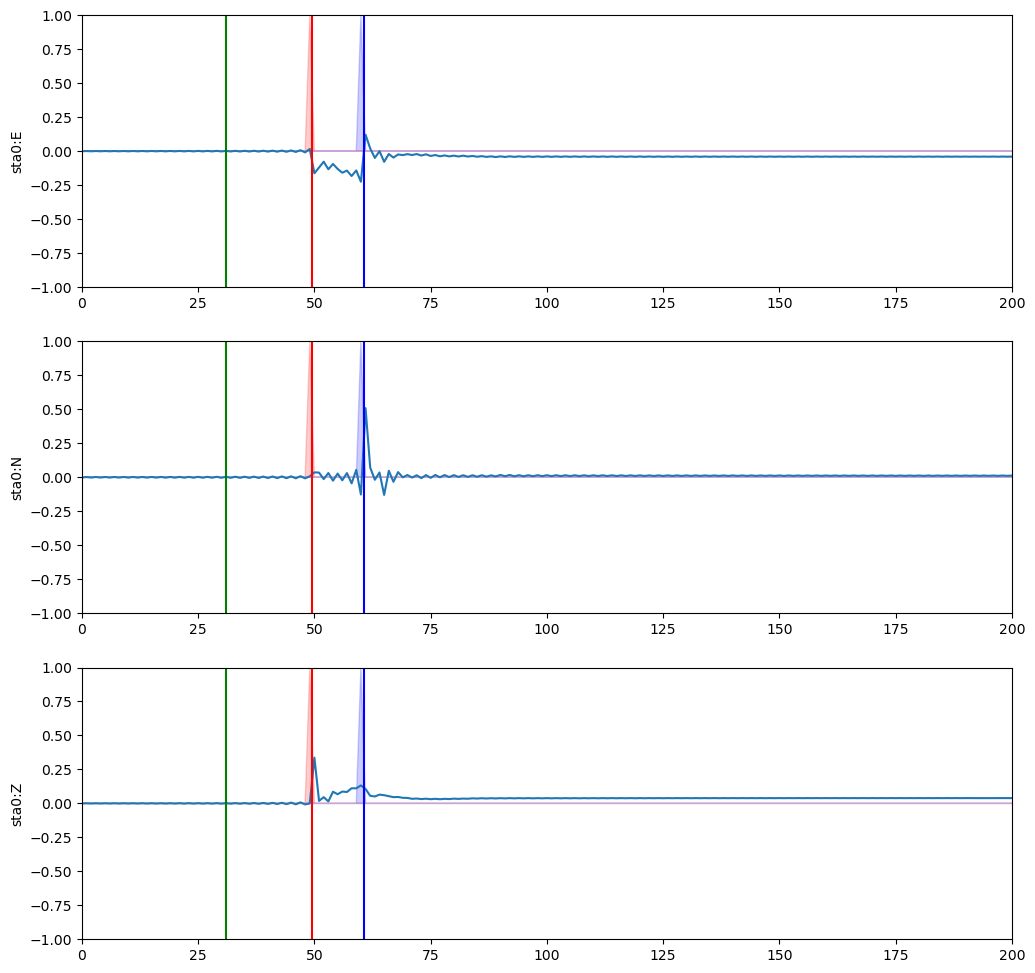

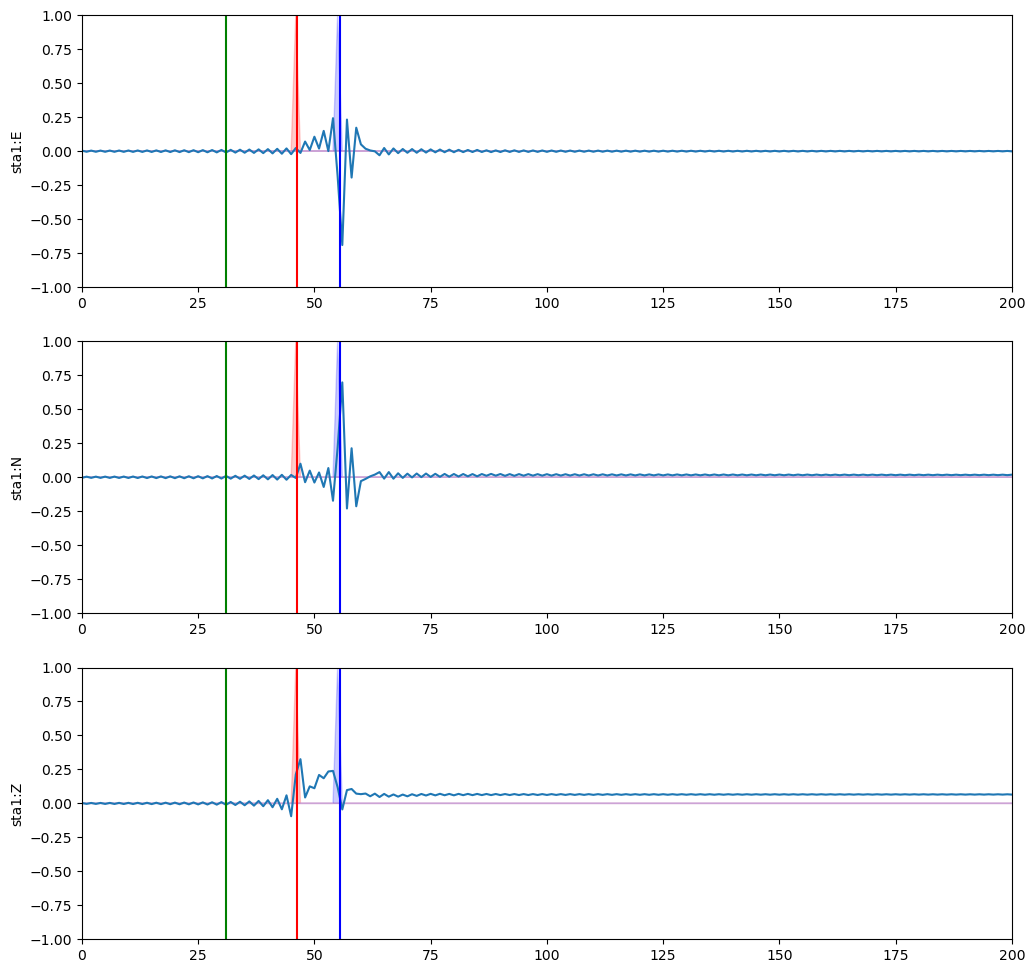

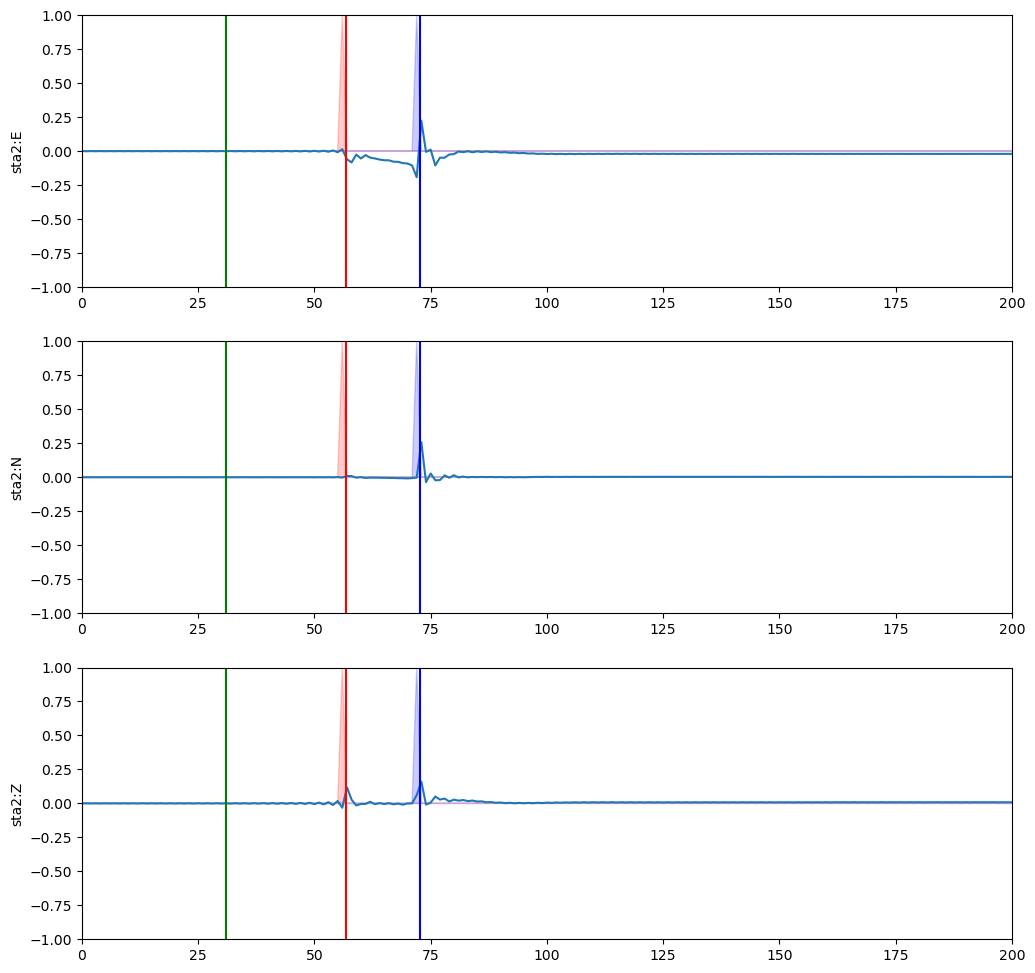

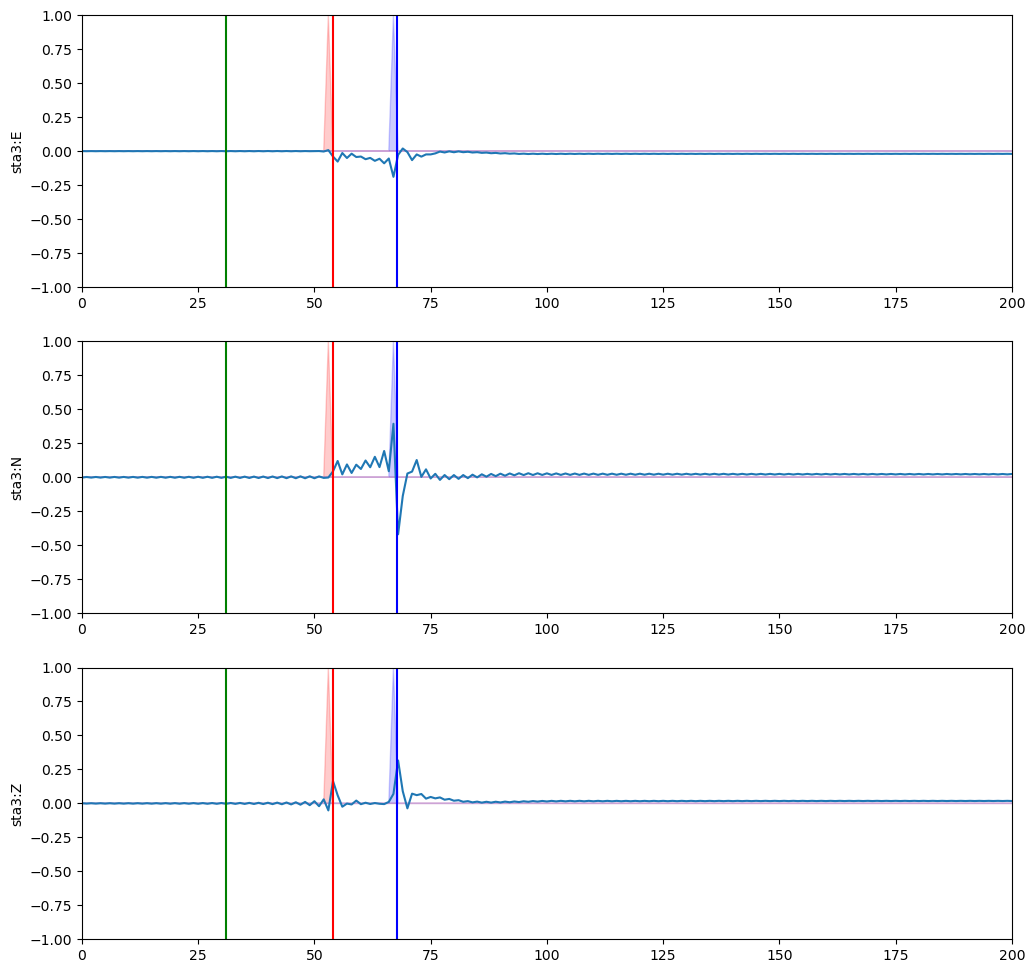

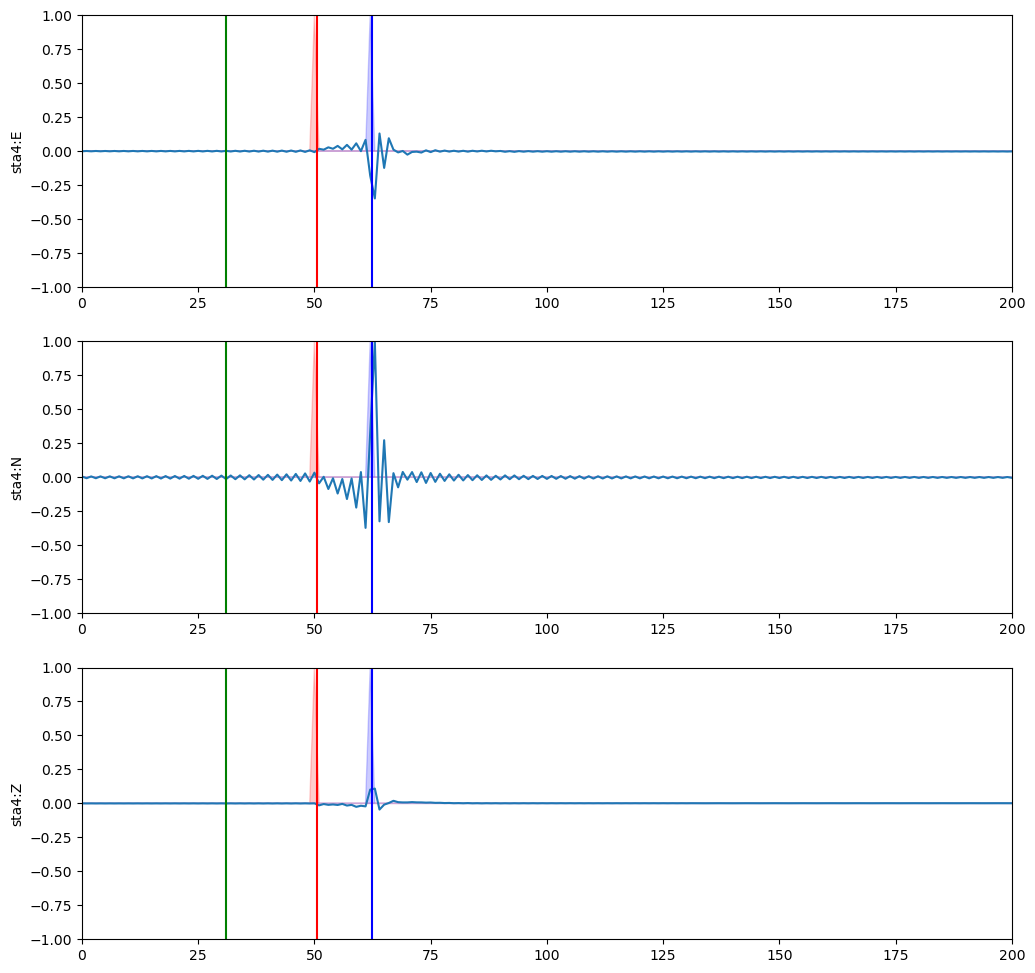

In [7]:
%%time
h5_path = '100k_wforms_disp_5stax3ch_with_saw_06_03_23.hdf5'

dataset = SynthSeism(h5_path = h5_path, transforms=transforms)

# all is fine
dataloader = DataLoader(dataset=dataset,
                      batch_size=10,
                      shuffle=True,
                      collate_fn=dataset.collate_fn, 
                      )

for X, y in dataloader:
    plot_event(X[0], y[0])
    break

### Сама модель. 
В модели важна возможность применять её для произвольного количества станций, при этом, при обработке каждой отдельной записи, должны учитываться все прочие. 

* В качестве признаков используется Log-wavelet scattering transform исходного сигнала (Andén J., Mallat S. Deep scattering spectrum // IEEE Transactions on Signal Processing. 2014. № 16 (62). C. 4114–4128.) Слой Wavelet Scattering (WS) формирует частотно-временное представление сигнала на основе вейвлет разложения, отчасти похожее на результат оконного преобразования Фурье. При этом WS обладает необходимыми свойствами устойчивости к искажениям исходного сигнала, сдвигам по времени и лучшего сохранения информации при разложении. Сам алгоритм представляет собой рекуррентную процедуру, в которой к исходному сигналу последовательно применяются операции вейвлет-пакетного разложения, взятия комплексного модуля и усреднения. С точки зрения нейронных сетей данный слой является аналогом сверточных слоев и операций макспуллинга. Но, если в сверточном слое фильтры проходят процедуру обучения, то в случае использования WS они представлены набором вейвлетов, что снимает неопределённость, связанную с необходимостью обучения фильтров. 
* В результате применения WS каждый сигнал преобразуется в 2D тензор с признаками. После этого прменяется двумерная свёртка с единичным размером ядра, преобразующая три канала записи каждой станции в один.
* Первый слой трансфомер энкодера. 2D представление каждого отдельно сигнала делится на временные фреймы и подаётся в трансформер энкодер для лучшего выделения области, в которой находится сигнал.
* Второй слой трансформер энкодера. Применяется к записям группы станций для обмена информации между ними.
* Выход слоя трансформера попадает на полносвязный слой. На выходе из модели для каждого события получается 2D тензор из one-hot векторов. Размерность тензора - (количство станций, количество фаз (p и s)).

Также в этом блоке переопределяется класс лосс функции. Это всё тот же BCELoss, но с большим штрафом за несовпадение с положительными метками. Это необходимо из-за несбалансированности целевых векторов: одно значение с меткой 1 на 399 нулевых значений.





In [20]:
class MySparseBCELoss(nn.Module):
    # Custom BCE loss. I need it because of unballanced targets
    def __init__(self, sparcity=1):
        super().__init__()
        self.sparcity = sparcity # approximate fraction of signals
        self.eps = 1e-6
        
    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        my_custom_bceloss = - torch.mean((1/self.sparcity) * target * torch.log(input + self.eps) +  torch.log(1-input + self.eps)) # fraction of y==1 labels multiplied by (1/self.sparcity)
        return my_custom_bceloss

class LogScat(nn.Module):
    '''
    Log-wavelet scattering transform. See https://www.kymat.io/index.html
    (..., trace vector) -> (...,  scat_shape 2D tensor)
    '''
    def __init__(self, J, rec_len, Q):
        super().__init__()
        self.scattering = Scattering1D(J, rec_len, Q).to(device)
        self.eps = 1e-6

    def forward(self, x):
        Sx = self.scattering(x)
        Sx[...,1:,:] = torch.log(torch.abs(Sx[...,1:,:]) + self.eps) # log for all coeffs except 0 order
        return Sx, self.scattering.meta()

class Conv_3_to_1(nn.Module):
    ''' 
    'Grayscale' chanels
    (..., ch num, scat_shape 2D tensor) -> (..., 1, scat_shape 2D tensor)
    '''
    def __init__(self, ch_in):
        super().__init__()
        self.conv = nn.Conv2d(ch_in, 1, 1)
    
    def forward(self, x):
        sh_x = x.shape
        x = x.flatten(0,1)
        x = self.conv(x) 
        x = x.unflatten(0, (sh_x[0], sh_x[1]))
        return x

class OneTraceTransformerEncoder(nn.Module):
    '''
    Performs attention over each single trace 
    (batch, sta num, scattering 2D) -> (batch, sta num, scattering flat vector time, scattering flat vector order) -> (batch, sta num, scattering 2D)
    size of emb vector ==  size of scattering flat vector
    '''
    def __init__(self, scat_shape, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.emb_size = scat_shape[0]
        self.nheads = scat_shape[0]
        self.encoder_layer = nn.TransformerEncoderLayer(self.emb_size, 1, batch_first=True) # one head. emb size is unpredictable 
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, self.num_layers)
    
    def forward(self, x):
        sh_x = x.shape 
        x = x.flatten(0,1) # batch, sta -> -1
        x = x.transpose(-1,-2) # scattering (order, time) <-> (time, order)   
        x = self.transformer_encoder(x)       
        x = x.transpose(-1,-2)
        x = x.unflatten(0, (sh_x[0], sh_x[1]))
        return x

class StaTransformerEncoder(nn.Module):
    '''
    Performs attention over the group of stantions
    (batch, sta num, scattering flat vector) -> (batch, sta num, emb vector)
    size of emb vector ==  size of scattering flat vector
    '''
    def __init__(self, scat_shape, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.emb_size = scat_shape[0] * scat_shape[1]
        self.nheads = scat_shape[0]
        self.encoder_layer = nn.TransformerEncoderLayer(self.emb_size, self.nheads, batch_first=True) # 16x50
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, self.num_layers)
    
    def forward(self, x):
        return self.transformer_encoder(x)

class Fc(nn.Module):
    # embeddings to outs (batch, sta num, emb vector) -> (batch, sta num, target tensor)
    def __init__(self, emb_size, rec_len):
        super().__init__()
        self.emb_size = emb_size
        self.rec_len = rec_len
        self.fc1 = nn.Linear(self.emb_size, 2*self.rec_len) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(2*self.rec_len, 2*self.rec_len) 
        self.sigm = nn.Sigmoid()
    
    def forward(self, x):
        bs = x.shape[0] # batch size
        x = x.flatten(0,1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigm(x)
        x = x.view(bs, -1, 2, self.rec_len) # 2 phases 
        return x

class Arrivals(nn.Module):
    '''
    Model itself
    waveforms -> arrivals
    '''
    def __init__(self, chanels, rec_len, one_tr_attn_nlayer, sta_attn_nlayer, J=3, Q=4):
        super().__init__()
        self.ch = chanels
        self.rec_len = rec_len

        # scattering
        self.scattering = LogScat(J=J, rec_len=self.rec_len, Q=Q)
        self.scat_shape, self.meta = self.get_scat_shape()
        
        # conv 3 ch -> 1 ch
        self.conv_3ch = Conv_3_to_1(self.ch)
        
        # one trace cross attention
        self.one_tr_transf = OneTraceTransformerEncoder(self.scat_shape, one_tr_attn_nlayer) 

        # stantion cross attention
        self.sta_transf = StaTransformerEncoder(self.scat_shape, sta_attn_nlayer)
        self.emb_size =  self.sta_transf.emb_size  # equal to flat scatt size

        # fc 
        self.fc = Fc(self.emb_size, self.rec_len)

    def forward(self, x):
        x, meta = self.scattering(x) # scattering
        x = self.conv_3ch(x).squeeze(-3) # 3 ch to one
        x = self.one_tr_transf(x) # attention over each singl trace 
        x = x.flatten(-2,-1) # img to line
        x = self.sta_transf(x) # attention over the group of stantions
        x = self.fc(x)
        return x

    def get_scat_shape(self):
        # returns scattering output shape
        foo = torch.randn(self.rec_len).to(device)
        bar, meta = self.scattering(foo)
        return bar.shape, meta



## Функции для обучения модели.

In [21]:
def train_one_epoch(model, train_dt, test_dl):
    loaders = {'train': train_dl, 'val': test_dl}
    model_modes = {'train': model.train, 'val': model.eval}
    losses = {'train': [], 'val': []}
    for mode in ['train', 'val']:
        model_modes[mode]() # model to train() or eval()
        for X, y_list_of_dicts in tqdm(loaders[mode]):
            y = torch.stack([yy['oh_arrivals'].to(device) for yy in y_list_of_dicts]) # target is a dict with all staf
            X = X.to(device)
            y_hat = model(X)
            l = loss(y_hat, y)
            if mode == 'train':
                optimizer.zero_grad()
                l.backward()
                optimizer.step()

        losses[mode] = l.item()
        
    return losses

def train_model(model, train_dt, test_dl):
    metrics = {'loss':{'train': [], 'val': []},
               'epoch': []} 
    model.to(device)
    for epoch in tqdm(range(epochs)):
        losses = train_one_epoch(model, train_dt, test_dl)
        metrics['epoch'].append(epoch)
        metrics['loss']['train'].append(losses['train'])
        metrics['loss']['val'].append(losses['val'])
        if epoch % 1 == 0:
            print(f"Epoch {epoch}:: train loss: {metrics['loss']['train'][-1]:.04f}, val loss: {metrics['loss']['val'][-1]:.04f}")

    return metrics

## Блок обучения и валидации модели. 

In [22]:
# model
model = Arrivals(chanels=3, rec_len=400, one_tr_attn_nlayer=1, sta_attn_nlayer=1, J=3, Q=4)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0:: train loss: 0.1410, val loss: 0.1375


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1:: train loss: 0.1087, val loss: 0.1046


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2:: train loss: 0.0960, val loss: 0.0878


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3:: train loss: 0.0837, val loss: 0.0796


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4:: train loss: 0.0773, val loss: 0.0731


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5:: train loss: 0.0734, val loss: 0.0708


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6:: train loss: 0.0696, val loss: 0.0662


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7:: train loss: 0.0652, val loss: 0.0618


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8:: train loss: 0.0650, val loss: 0.0618


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 9:: train loss: 0.0645, val loss: 0.0595


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10:: train loss: 0.0602, val loss: 0.0566


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 11:: train loss: 0.0591, val loss: 0.0559


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 12:: train loss: 0.0677, val loss: 0.0563


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 13:: train loss: 0.0582, val loss: 0.0553


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 14:: train loss: 0.0642, val loss: 0.0581


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 15:: train loss: 0.0612, val loss: 0.0535


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 16:: train loss: 0.0586, val loss: 0.0536


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 17:: train loss: 0.0540, val loss: 0.0507


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 18:: train loss: 0.0580, val loss: 0.0522


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 19:: train loss: 0.0532, val loss: 0.0524


ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.


RuntimeError: Parent directory /model_states does not exist.

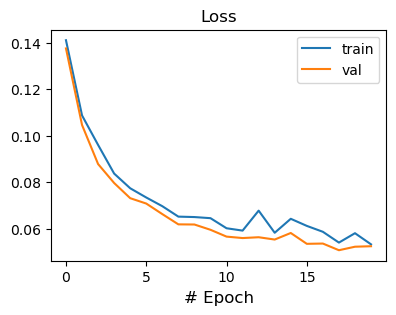

In [23]:
%%time
h5_path = '100k_wforms_disp_5stax3ch_with_saw_06_03_23.hdf5'

dataset = SynthSeism(h5_path = h5_path, transforms=transforms)

# splitting the dataset into the train and test set
torch.manual_seed(1)
set_size = len(dataset)
test_share = 0.2
rand_idxs = torch.randperm(set_size).tolist()

train = torch.utils.data.Subset(dataset, rand_idxs[:-int(test_share*set_size)])
test = torch.utils.data.Subset(dataset, rand_idxs[-int(test_share*set_size):])

# train = torch.utils.data.Subset(dataset, rand_idxs[:1000]) # for testing
# test = torch.utils.data.Subset(dataset, rand_idxs[1000:2000])


train_dl = DataLoader(dataset=train,
                      batch_size=100,
                      shuffle=True,
                      collate_fn=dataset.collate_fn, 
                      )

test_dl = DataLoader(dataset=test,
                      batch_size=100,
                      shuffle=False,
                      collate_fn=dataset.collate_fn, 
                      )

# loss
loss =  MySparseBCELoss(sparcity = 0.0025) # 1 signal on 400 points

# optimizer
epochs = 20
lr = 0.0001 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

metrics = train_model(model, train_dl, test_dl)
plot_metrics(metrics)

#saving path
!mkdir -p model_states
pt_path = 'model_states/'+'state_dict_'+ datetime.now().strftime("%m_%d_%Y__%H_%M_%S") +'.pt'
torch.save(model.state_dict(), pt_path)


### проверка модели

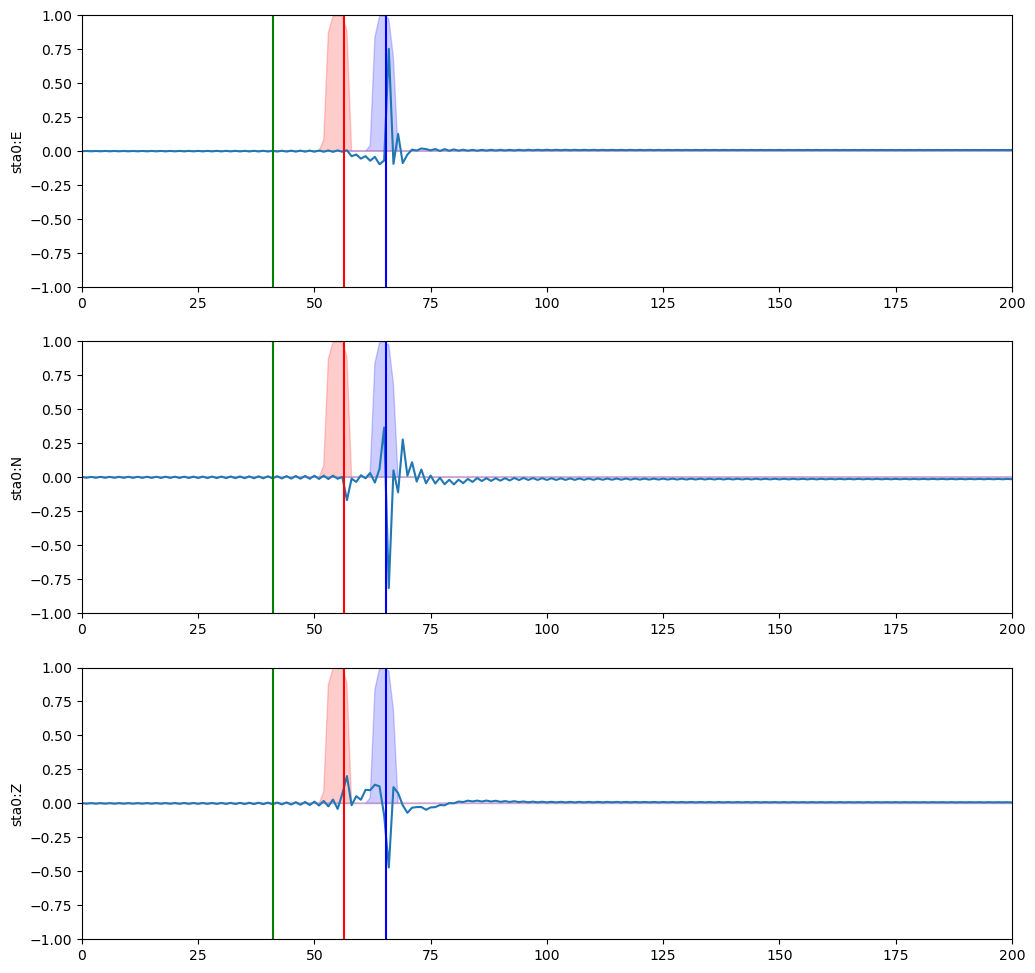

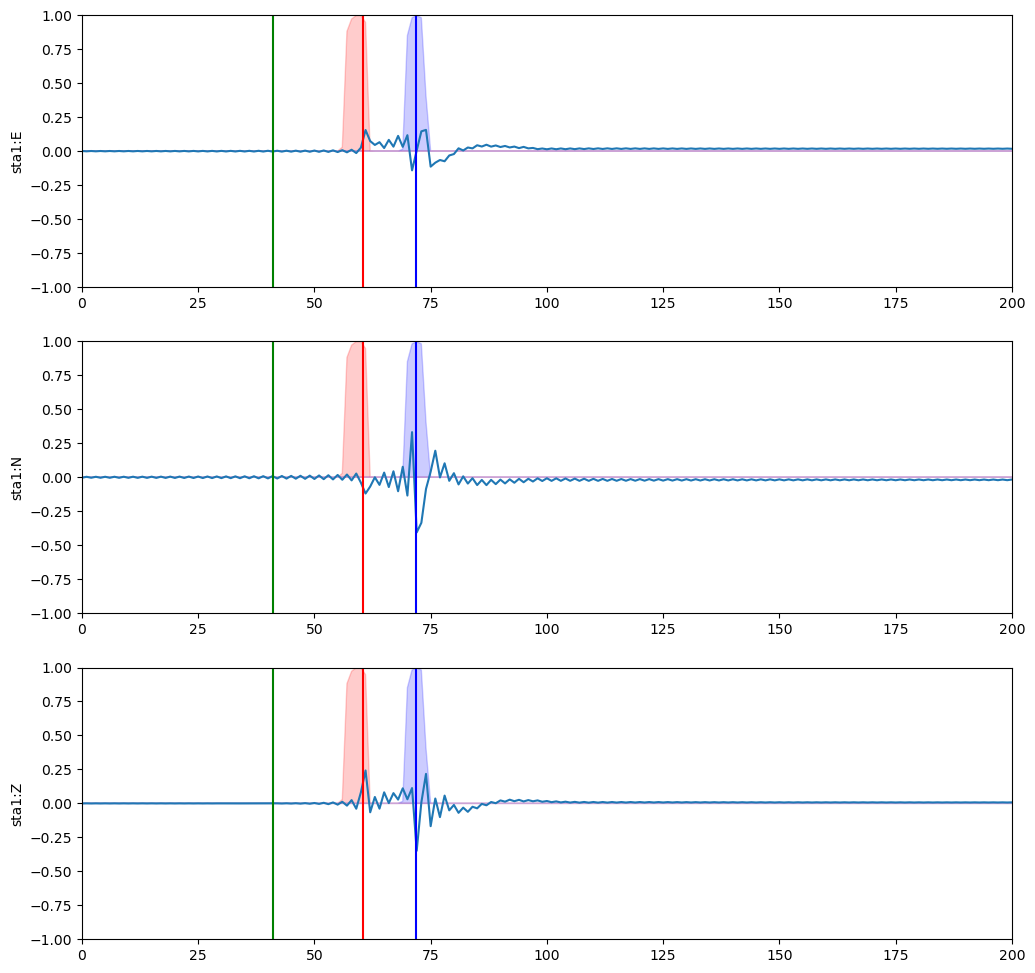

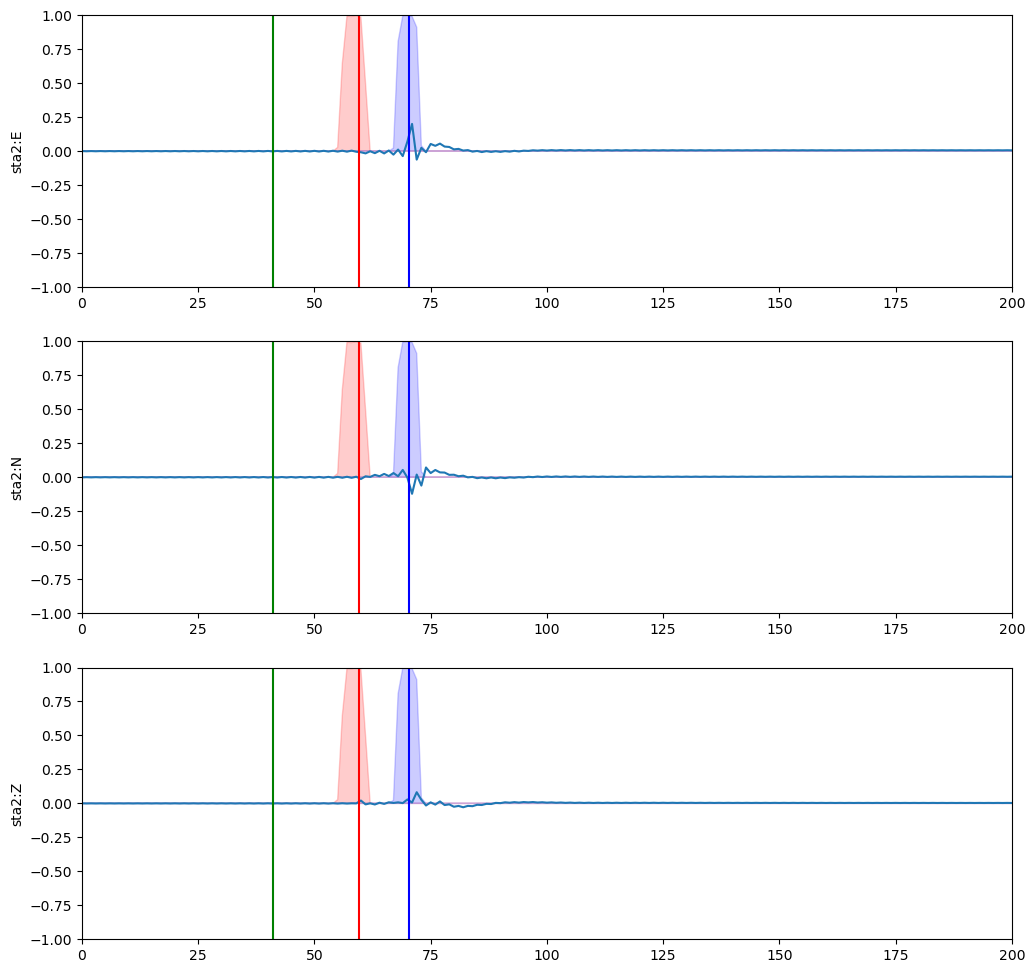

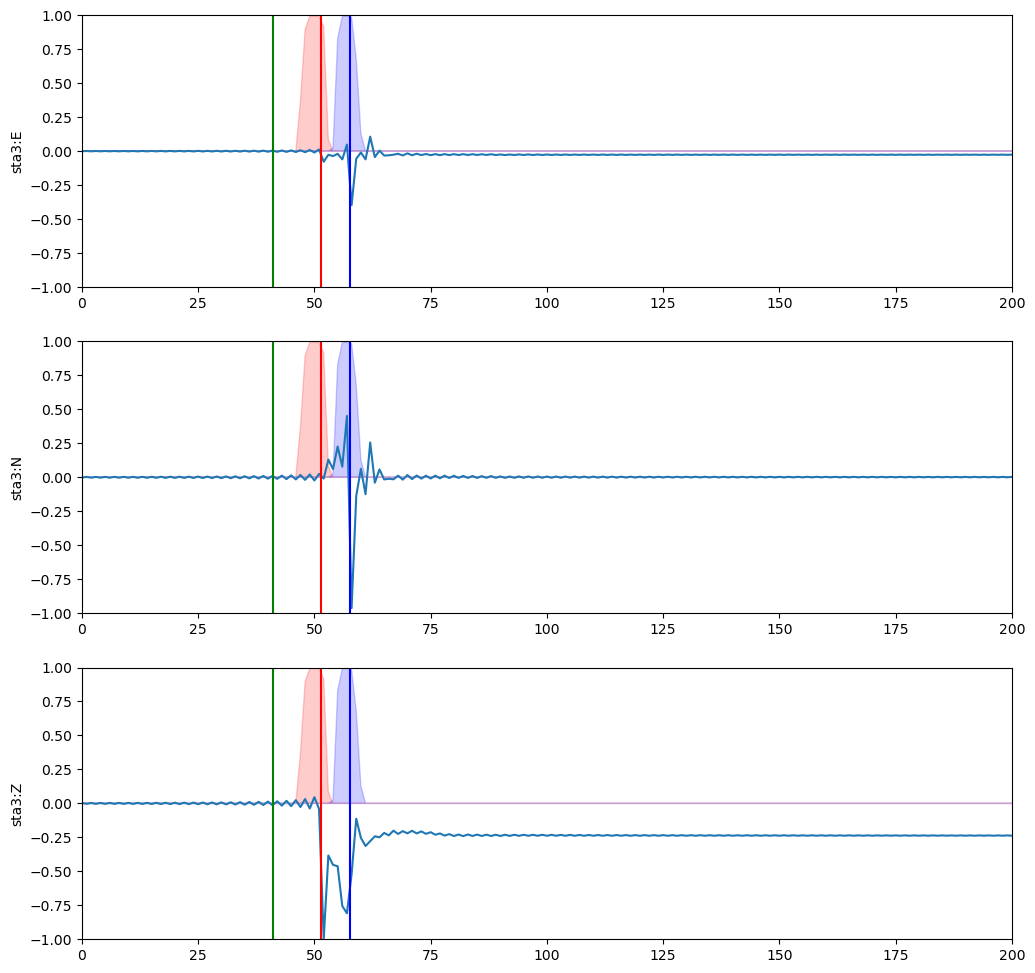

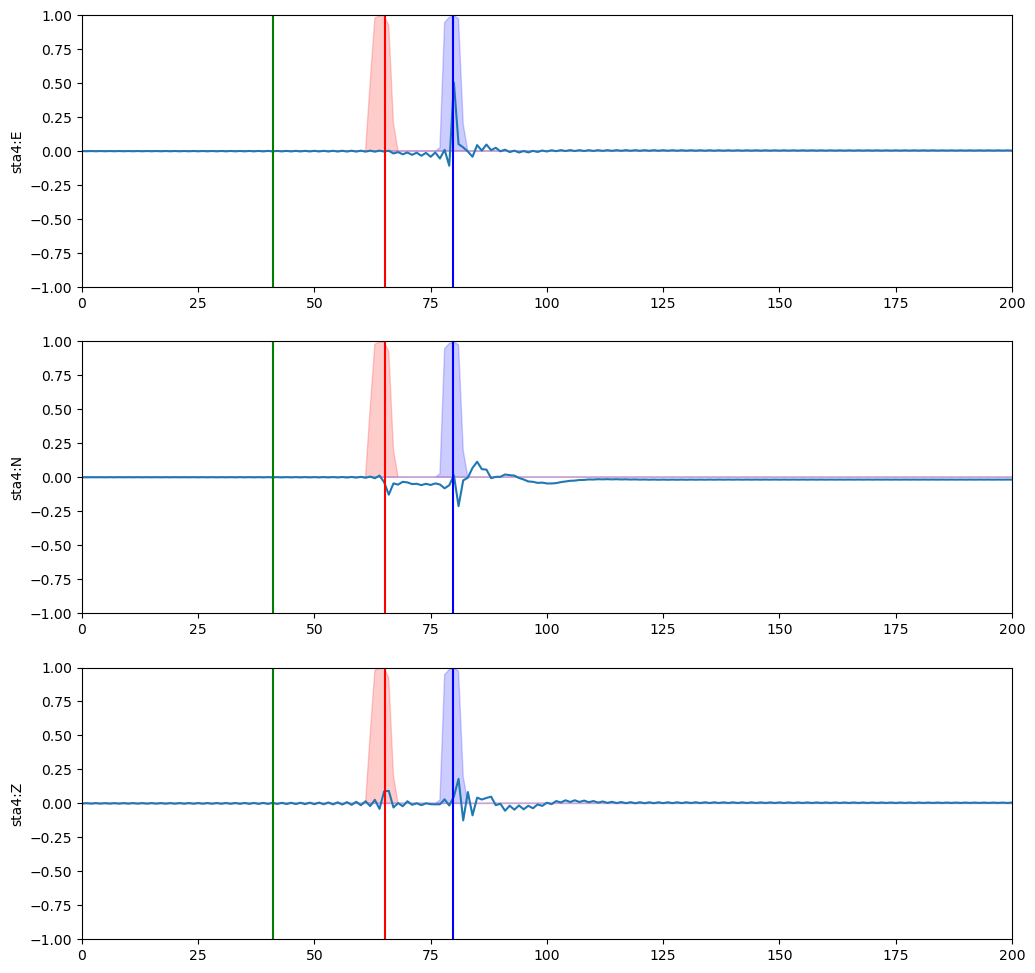

In [29]:
# loading last save
# model.load_state_dict(torch.load(pt_path))

model.cpu()
model.eval()
x,y = train[69]
y_hat = model(x.unsqueeze(0)).squeeze(0)
plot_event(x, y, y_hat.detach().numpy())

## Дальше всякие рабочие моменты, связынные с отладкой. В работе программы не используются.

In [ ]:

class Fc(nn.Module):
    # embeddings to outs (..., emb vector) -> (..., target tensor)
    def __init__(self, sta_n, ch_in, rec_len, scat_shape):
        super().__init__()
        self.emb_size = scat_shape[0] * scat_shape[1]
        self.rec_len = rec_len
        self.ch_in = ch_in
        self.sta_n = sta_n
        self.fc1 = nn.Linear(self.emb_size, 3*self.rec_len) 
        self.relu = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(3*self.rec_len, 3*self.rec_len) 
        self.sigm = nn.Sigmoid()
    
    def forward(self, x):
        x = x.flatten(0,1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigm(x)
        x = x.view(-1, self.sta_n, 3, self.rec_len)     
        return x

class StaTransformer(nn.Module):
    # (..., scattering flat vector) -> (..., emb vector)
    def __init__(self, scat_shape, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.emb_size = scat_shape[0] * scat_shape[1]
        self.nheads = scat_shape[0]
        self.encoder_layer = nn.TransformerEncoderLayer(self.emb_size, self.nheads, batch_first=True) # 16x50
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, self.num_layers)
    
    def forward(self, x):
        return self.transformer_encoder(x)


sc = LogScat(J=3, N=400, Q=4)
conv = Conv_3_to_1(ch_in=3)
transf = StaTransformer(torch.Size([16,50]), 2)
fc = Fc(5,3,400, torch.Size([16,50]))

Sx,_ = sc(X)
Cx = conv(Sx)
Fx = Cx.flatten(-2,-1).squeeze(-2)
Tx = transf(Fx)
out = fc(Tx)
out.shape

torch.Size([10, 5, 3, 400])

torch.Size([10, 5, 3, 16, 50])


Text(0.5, 1.0, 'Time-Frequency spectrogram of signal')

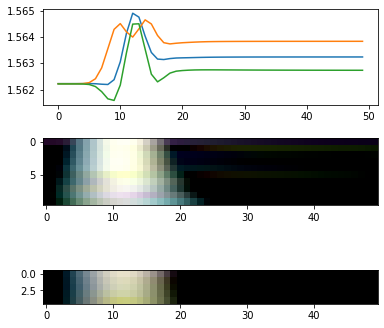

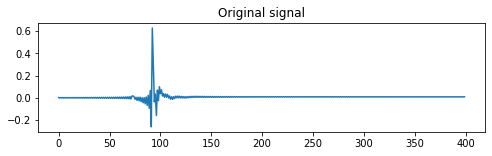

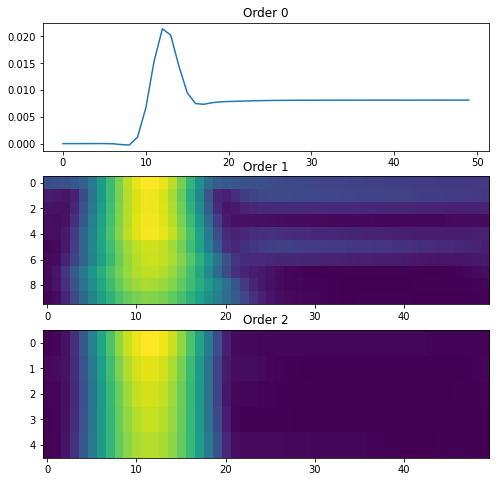

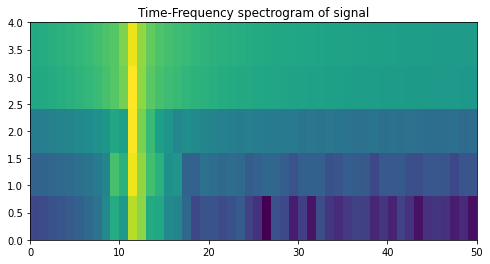

In [ ]:
sc = LogScat(J=3, N=X.shape[-1], Q=4)

Sx, meta = sc(X)
print(Sx.shape)

img = Sx[0][0]
mean, std = torch.mean(img), torch.std(img)
img  = ((img-mean)/std +0.5)/2
# m = nn.Sigmoid()
# img= m(img)
fig, ax = plt.subplots(3,1, figsize=(6, 6))
ax[0].plot(img.permute(1, 2, 0).numpy()[0])
ax[1].imshow(img.permute(1, 2, 0).numpy()[1:11])
ax[2].imshow(img.permute(1, 2, 0).numpy()[11:])


order = [np.where(meta['order'] == order) for order in [0,1,2]]
x = X[0][0][0]

# signal
plt.figure(figsize=(8, 2))
plt.plot(x)
plt.title('Original signal')

# 0 order
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(Sx[0][0][0][order[0]][0])
plt.title('Order 0')

# 1-2 order
for ii in [1,2]:
    plt.subplot(3, 1, ii+1)
    plt.imshow(Sx[0][0][0][order[ii]], aspect='auto')
    plt.title(f'Order {ii}')

plt.figure(figsize=(8, 4))
plt.specgram(x, Fs=8, NFFT=8, noverlap=0, detrend='mean')
plt.title("Time-Frequency spectrogram of signal")

In [ ]:
meta
# https://github.com/kymatio/kymatio/blob/main/kymatio/scattering1d/filter_bank.py
# psi(t) = g_{sigma}(t) (e^{i xi t} - kappa)
# central frequency
# 'xi': normalized center frequency, where 0.5 corresponds to Nyquist.
# about meta https://github.com/kymatio/kymatio/blob/main/kymatio/scattering1d/frontend/base_frontend.py

{'order': array([0, 1, 1, 1, 1, 2, 2, 2]), 'xi': array([[    nan,     nan],
        [0.35   ,     nan],
        [0.175  ,     nan],
        [0.0875 ,     nan],
        [0.04375,     nan],
        [0.35   , 0.04375],
        [0.175  , 0.04375],
        [0.0875 , 0.04375]]), 'sigma': array([[       nan,        nan],
        [0.14013095,        nan],
        [0.07006547,        nan],
        [0.03503274,        nan],
        [0.01751637,        nan],
        [0.14013095, 0.01751637],
        [0.07006547, 0.01751637],
        [0.03503274, 0.01751637]]), 'j': array([[nan, nan],
        [ 0., nan],
        [ 0., nan],
        [ 0., nan],
        [ 1., nan],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]]), 'n': array([[nan, nan],
        [ 0., nan],
        [ 1., nan],
        [ 2., nan],
        [ 3., nan],
        [ 0.,  3.],
        [ 1.,  3.],
        [ 2.,  3.]]), 'key': [(),
  (0,),
  (1,),
  (2,),
  (3,),
  (0, 3),
  (1, 3),
  (2, 3)]}

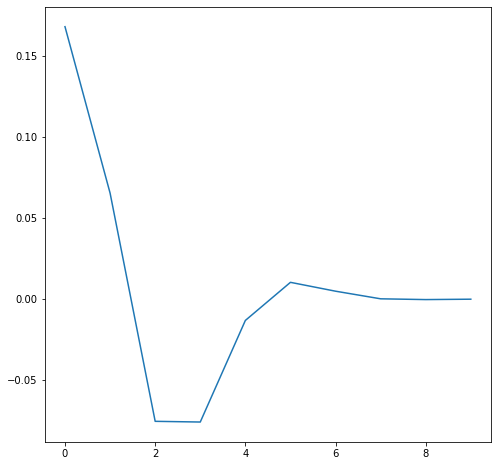

In [ ]:
from kymatio.scattering1d.filter_bank import scattering_filter_factory
from scipy.fft import fft, ifft, fftfreq

# psi(t) = g_{sigma}(t) (e^{i xi t} - kappa)

T=2**12
J=10
Q= (1,1)
phi_f, psi1_f, psi2_f = scattering_filter_factory(T, J, Q, T)

yf = psi1_f[1]['levels'][0]

plt.figure(figsize=(8, 8))
plt.plot(ifft(yf)[0:10])

In [ ]:
psi1_f

[{'levels': [array([ 0.00000000e+00,  7.51697631e-07,  1.50340807e-06, ...,
          -2.25501565e-06, -1.50335645e-06, -7.51684434e-07])],
  'xi': 0.35,
  'sigma': 0.14013094769175247,
  'j': 0},
 {'levels': [array([-5.21180213e-18,  1.50466153e-06,  3.00937422e-06, ...,
          -4.51367769e-06, -3.00916961e-06, -1.50461038e-06])],
  'xi': 0.175,
  'sigma': 0.07006547384587623,
  'j': 0},
 {'levels': [array([-5.21180212e-18,  3.00937421e-06,  6.01895304e-06, ...,
          -9.02689503e-06, -6.01813461e-06, -3.00916961e-06])],
  'xi': 0.0875,
  'sigma': 0.03503273692293812,
  'j': 0},
 {'levels': [array([-5.21180212e-18,  6.01895304e-06,  1.20387246e-05, ...,
          -1.80519488e-05, -1.20354509e-05, -6.01813461e-06])],
  'xi': 0.04375,
  'sigma': 0.01751636846146906,
  'j': 1},
 {'levels': [array([-5.21180212e-18,  1.20387246e-05,  2.40807233e-05, ...,
          -3.60965333e-05, -2.40676284e-05, -1.20354509e-05])],
  'xi': 0.021875,
  'sigma': 0.00875818423073453,
  'j': 2},
 {'le

In [ ]:
x = torch.randn((2,2,3,5))
print(x[0][0])
x = x.transpose(-1,-2)
print(x[0][0])

tensor([[ 0.9784, -0.7426,  1.3370, -0.1998,  1.0106],
        [-0.0799, -1.2510,  0.0906,  0.5961, -1.8122],
        [ 0.9360, -0.8619,  0.2101,  0.6799, -0.5185]])
tensor([[ 0.9784, -0.0799,  0.9360],
        [-0.7426, -1.2510, -0.8619],
        [ 1.3370,  0.0906,  0.2101],
        [-0.1998,  0.5961,  0.6799],
        [ 1.0106, -1.8122, -0.5185]])


### Sakhalin dataset operations (not used yet)



In [ ]:
h5_path = '/content/data/SAKH-2014_2021_global_norm.h5'
with h5py.File(h5_path, 'r') as f:
    X, Y = (f['X'][:], f['Y'][:])

trace_no = 0 # event
chnlz= [0, 1, 2] # chanels

fig, ax = plt.subplots(3,1, figsize=(8,6*2))
with h5py.File(h5_path, 'r') as f:
    for ii in chnlz:
        ax[ii].plot(f[f"X"][trace_no][:,ii])
        ax[ii].set_title(f'Label: {f["Y"][trace_no]}') # 0 = p, 1 = s, 2 = noise ?
